# Hide and Hade traditional Sparse Coding
**Author: Thomas Rolland**

Implementation of traditional Sparse Coding on the Hide/Hade dataset, using only raw signal.
In order to to that we take some windows on the raw signal (size:512, overlay: 256). And apply Sparse Coding and dictionary learning on all obtained windows.

If you have any question, send me an email at: trolland@protonmail.ch

In [1]:
from scipy.io import wavfile
import numpy as np
import os
import math
import matplotlib.pyplot as plt
# For spectrogram, only usefull for print information about the signal
from scipy import signal

In [2]:
path_Hide = "/baie/corpus/Hade_Hide/wavCut/hide"
path_Hade = "/baie/corpus/Hade_Hide/wavCut/hade"

In [3]:
data = []
for file in os.listdir(path_Hade):
    fs, value = wavfile.read(path_Hade+"/"+file)
    data.append(value)
for file in os.listdir(path_Hide):
    fs, value = wavfile.read(path_Hide +"/"+file)
    data.append(value)
X = np.array(data)
#X = np.array(data)
print(X.shape)

(2499,)


#### Display the full signal and the corresponding spectrogram

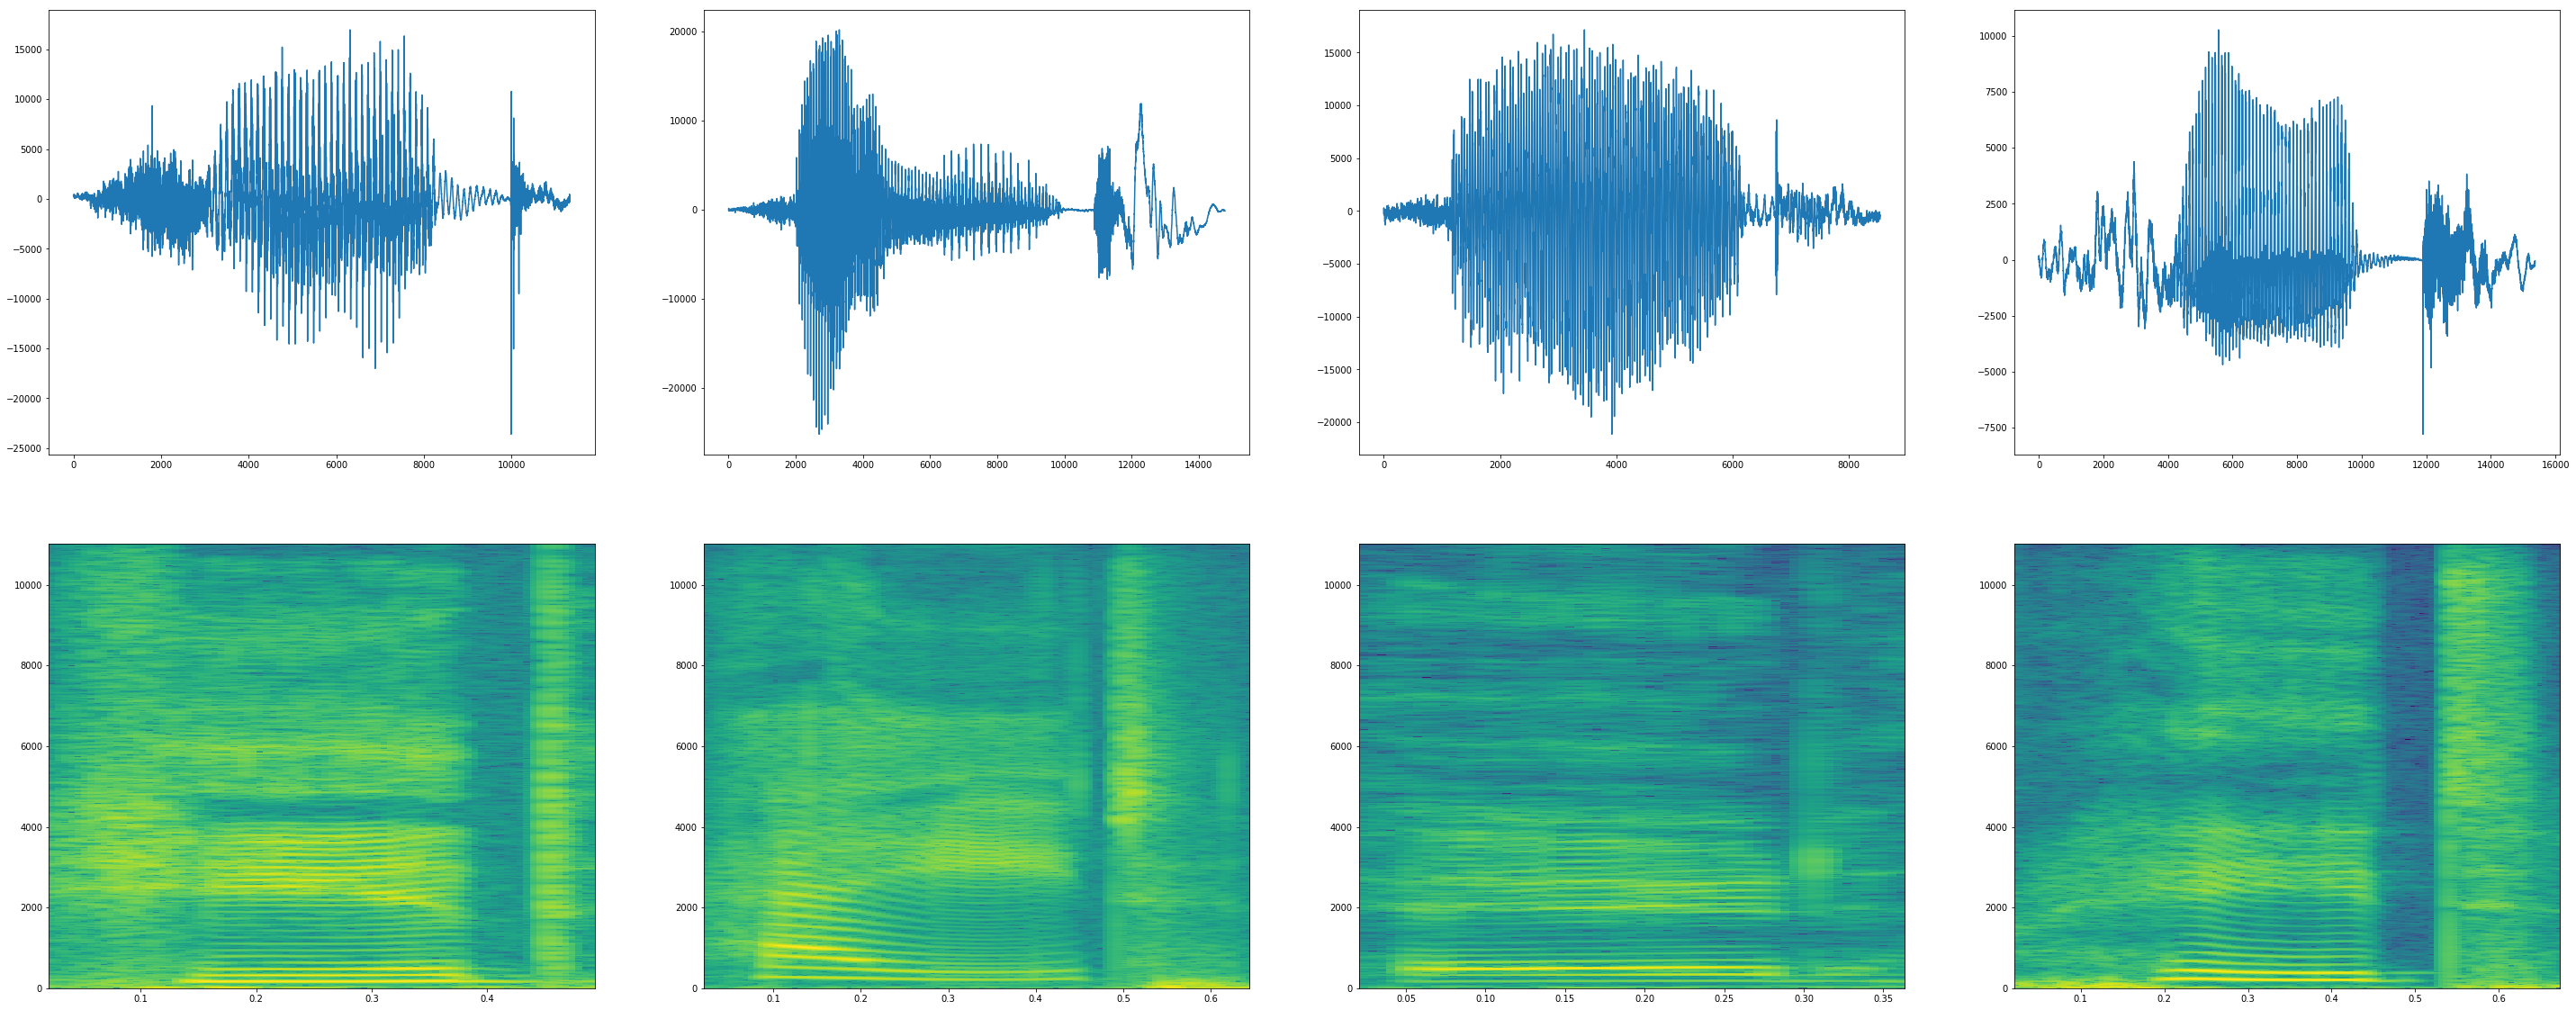

In [4]:
NFFT = 1024
n = 4  # how many signal we will display
plt.figure(figsize=(50, 20))
for i in range(n):
    # display raw signal
    ax = plt.subplot(2, n, i + 1)
    plt.plot(X[30+i])
    # Display sectogram
    ax = plt.subplot(2, n, i + 1 + n)
    Pxx, freqs, bins, im = plt.specgram(X[30+i], NFFT=NFFT, Fs=fs, noverlap=900)

plt.show()

In [5]:
#NFFT = 1024
#for i in range(10):
    # Pxx is the segments x freqs array of instantaneous power, freqs is
    # the frequency vector, bins are the centers of the time bins in which
    # the power is computed, and im is the matplotlib.image.AxesImage
    # instance
#    Pxx, freqs, bins, im = plt.specgram(X[i], NFFT=NFFT, Fs=fs, noverlap=900)
#    plt.show()

##### Diplay usefull information about the duration (min and max for all sample)
It could be usefull if we want to implement a padding function

In [6]:
sizeTab = []
for i in range(len(X)):
    sizeTab.append(X[i].shape)
print("Minimum sample: "+str('{:.2e}'.format(min(sizeTab)[0]/fs)) + " second(s)") # Shortest samples
print("Maximum sample: "+ str('{:.2e}'.format(max(sizeTab)[0]/fs)) + "second(s)") # Longest sample


Minimum sample: 3.05e-01 second(s)
Maximum sample: 8.88e-01second(s)


### Usefull function

In [7]:
def window(data, size,overlaying):
    """
        window algorithm: Return the vector of windows extract from the signal
        
        Parameters
        ----------
        data  : np.array
            Sample 
        size  : np.array
            window's size
        Overlaying:
            overlay between two window
        
        Note: 
        In this context of Hide and Hade dataset, the last windows (which size is less the SIZE parameter isn't keep)
        because the usefull information isn't in this window

    """
    n = len(data) # sample's size
    newData = []
    idxBegin = 0
    idxEnd = size
    while idxEnd < n:
        newData.append(data[idxBegin:idxEnd])
        idxBegin += overlaying
        idxEnd += overlaying
    return newData


In [8]:
# Apply window function on all our dataset
for i in range(len(X)):
    temp = window(X[i],512,256)
    if i == 0:
        newData = temp
    else:
        newData = np.concatenate([newData,temp])
# All windows for all sample concatenate
print(newData.shape)

(115536, 512)


### Display window 

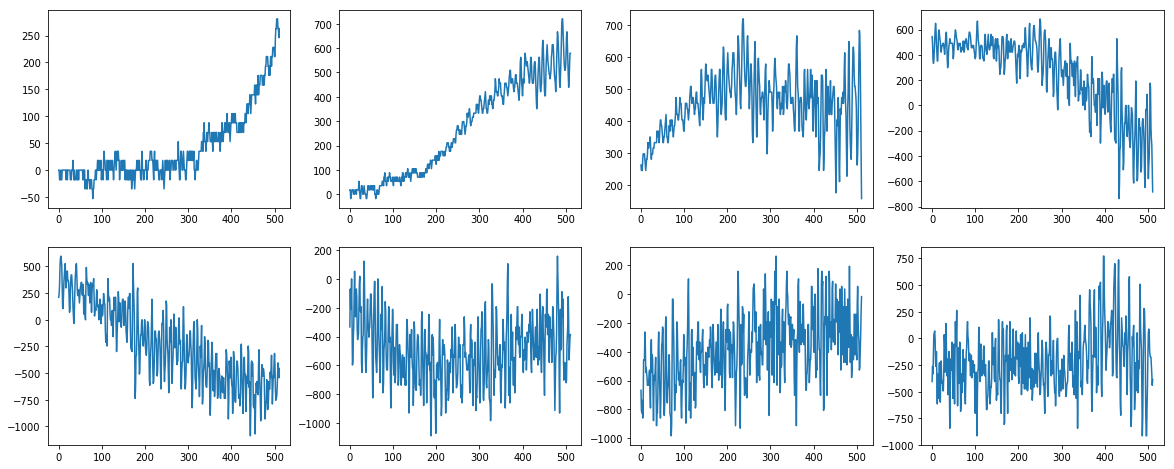

In [9]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display raw signal
    ax = plt.subplot(2, n, i + 1)
    plt.plot(newData[i])
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(newData[i+n])
    #Pxx, freqs, bins, im = plt.specgram(X[30+i], NFFT=NFFT, Fs=fs, noverlap=900)

plt.show()

# Sparse Coding Step

Preprocessing data

In [10]:
import spams

X = np.transpose(newData)
[m,n] = np.shape(X)
X = np.asfortranarray(X,dtype=float)
# Lambda1 
lambda1 = 1.2/math.sqrt(m) # see Traditonal Sparse coding notebook for more information
# Number of atoms
k = 1024 
# Dictionary learing parameters
param = {'mode':5, 'K':k,'lambda1':lambda1,'numThreads':5,'batchsize':256,'iter':200}

# Find a overcomplete dictionary
D = spams.trainDL(X,**param)

# Find sparse linear combination

# here we only compute for the 10 first elements 
X = np.transpose(newData[:10])
X = np.asfortranarray(X,dtype=float)

H = spams.omp(X,D,lambda1=lambda1)


## Display results

In [11]:
# Get all data for display
H_dis = np.transpose(H.todense()) 
recons = D @ H
recons = np.transpose(recons)


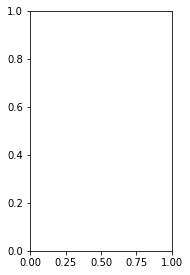

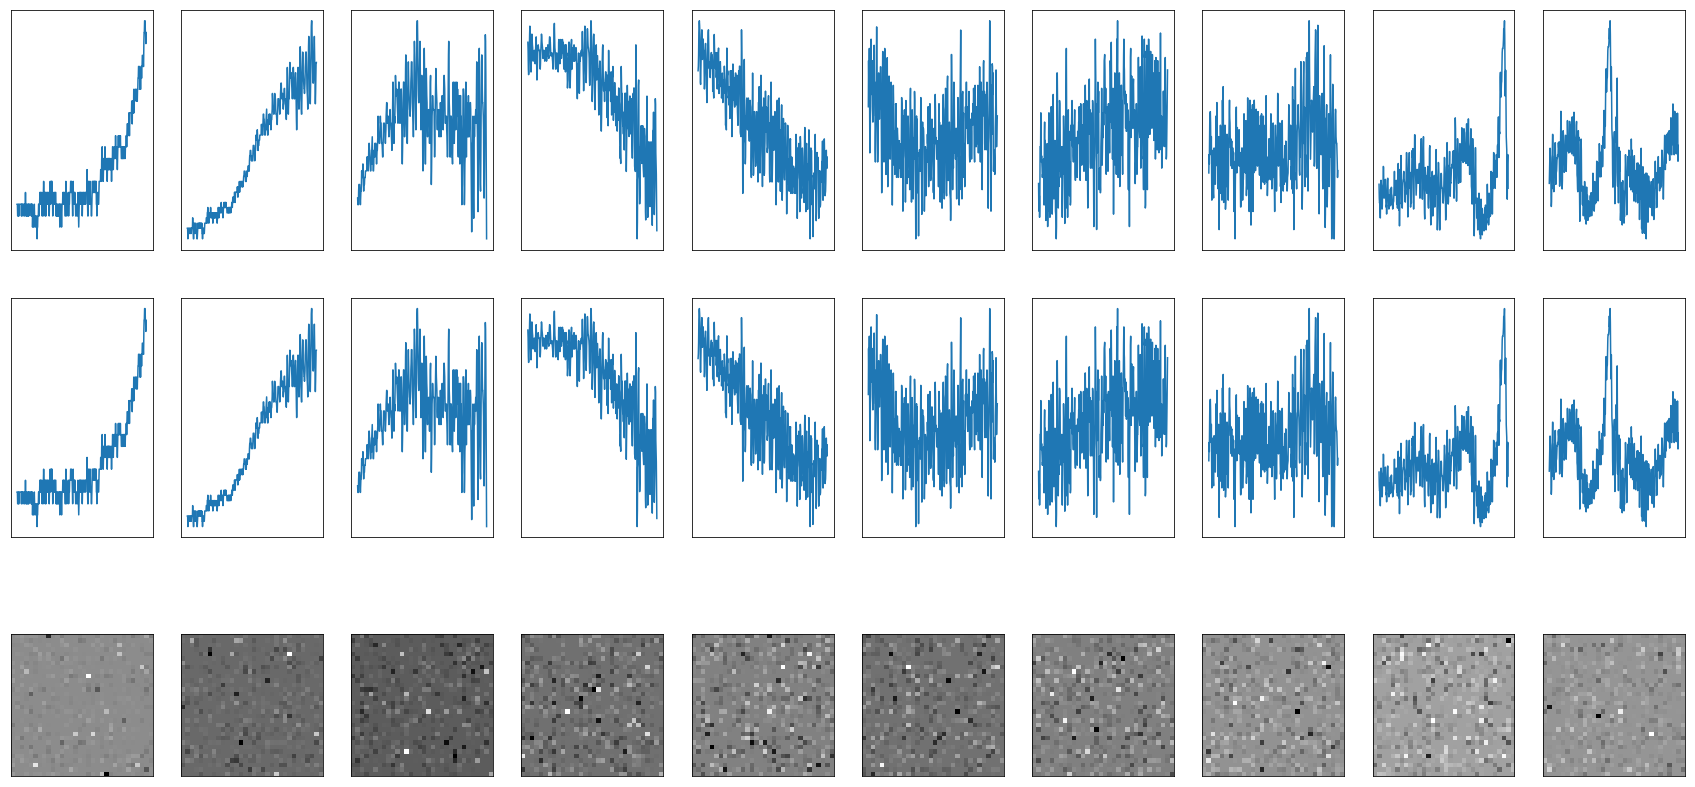

In [13]:
plt.figure(figsize=(30,15))

n_show = 10 #  number of image that we show
for i in range(n_show):
    # display original
    ax = plt.subplot(3,n_show,i+1)
    plt.plot(newData[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3,n_show,i+1+n_show)
    plt.plot(recons[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display coef
    ax = plt.subplot(3,n_show,i+1+2*n_show)
    plt.imshow(H_dis[i].reshape(32,32))
    # Here we choose this reshape because H in [nb_samples, 2000]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()